In [43]:
import fastai

In [44]:
# !pip install -U fastbook

In [45]:
import fastbook
fastbook.setup_book

<function fastbook.setup_book()>

In [46]:
from fastbook import *
from fastai.vision.widgets import*

In [47]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [48]:
ims  = search_images_ddg('grizzly bear')
len(ims)

200

In [49]:
import os

In [50]:
os.chdir('D:\FAST.AI\l1')


In [51]:
dest = 'bears/grizzly.jpg'


In [52]:
download_url(ims[1],dest,show_progress=True)

Path('bears/grizzly.jpg')

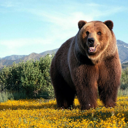

In [53]:
im = Image.open(dest)
im.to_thumb(128,128)

In [54]:
bear_types = 'grizzly','black','teddy'
path = Path('bear')

In [55]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest,urls=results)

In [56]:
fns  = get_image_files(path)
fns

(#508) [Path('bear/black/00c7f9ea-4288-4db9-b215-57bd01408d52.jpg'),Path('bear/black/010d1c32-80b8-4a99-ba9a-1372d142815b.jpg'),Path('bear/black/053e72cc-1f77-4e79-b866-13df1634e7eb.jpg'),Path('bear/black/05c3e39e-ab0b-4ce8-9e3f-7281fbb5a30e.jpg'),Path('bear/black/0c83667a-02ec-4b88-ad0f-9887f4ba116f.jpg'),Path('bear/black/0e7171a5-064f-4188-9de7-09d4c5e55c1d.jpg'),Path('bear/black/0f9e759f-e9e8-46eb-9ac7-c465a67c168e.jpg'),Path('bear/black/136abc40-fe52-418c-ae6a-48ba561d94f7.jpg'),Path('bear/black/14efe886-f8fd-4ff1-8e27-59fd6e9288d2.jpg'),Path('bear/black/1664e82f-ffbe-4500-b21a-941a7def66bd.jpg')...]

In [57]:
failed = verify_images(fns)
len(failed)

80

In [58]:
from pathlib import Path
for file in failed:
    Path(file).unlink()

### To find the meaning of any function just put ? infront of it

In [34]:
# ??verify_images

### Before cleaning the data we train the model unintuitive

In [59]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [60]:
dls = bears.dataloaders(path)

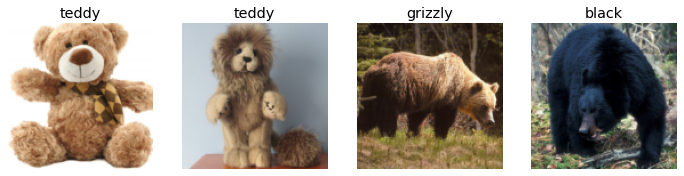

In [61]:
dls.valid.show_batch(max_n=4,nrows=1)

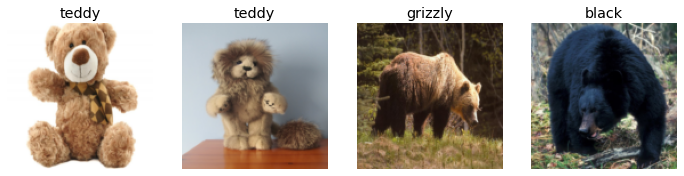

In [62]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

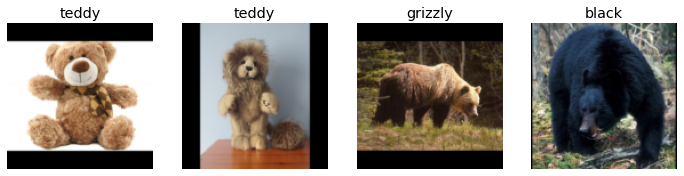

In [63]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

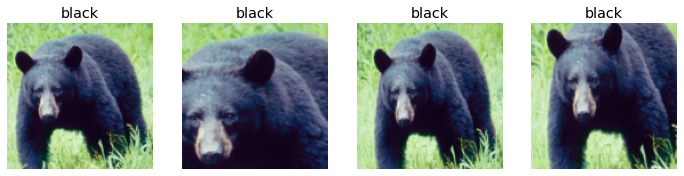

In [64]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

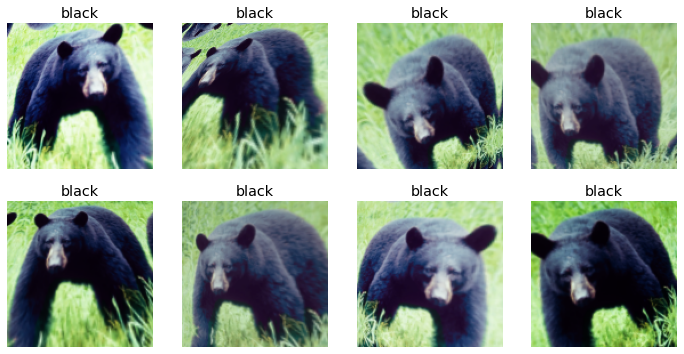

In [65]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [66]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [67]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.423823,0.220377,0.047059,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.226461,0.204674,0.035294,00:39
1,0.218818,0.244936,0.035294,00:38
2,0.167011,0.274021,0.035294,00:39
3,0.141398,0.274439,0.035294,00:39


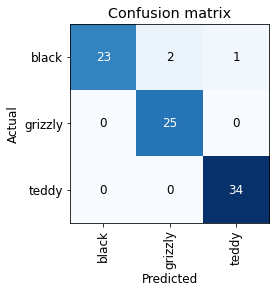

In [69]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

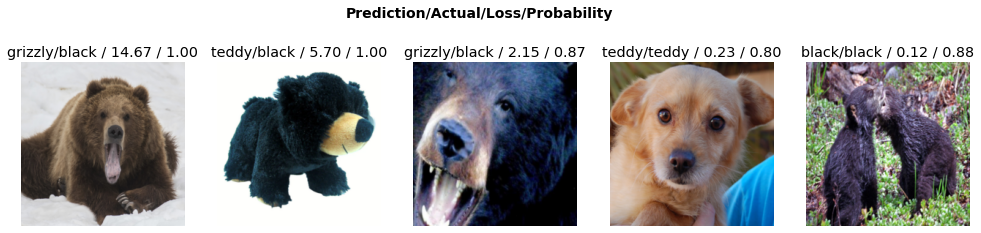

In [70]:
interp.plot_top_losses(5, nrows=1,figsize=(17,4))#shows where loss is the highest
#in the first image here we predicted black but it is grizzly itseems and it was 1.00 sure.. grizzly/grizzly is because the model was not that sure abt its correctness

In [73]:
cleaner = ImageClassifierCleaner(learn)
cleaner #used to remove wrongly labelled in our dataset

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\FAST.AI\\l1\\bear\\black\\3063e364-e1c5-4908-a91a-5d91295630a9.jpg'

In [72]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()#deletes all that we set to delete 
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)#changes all the changes we made

In [1]:
#so always before cleaning train once so to find out what things are difficult to recognize in your data, so you know better ways to find the next dataset